# Machine Learning II: Deep Learning and Applications
# Homework 3

**Due date: Apr 20**

### Instructions
- Make a copy of this notebook in your own Colab and complete the questions there.
- You can add more cells if necessary. You may also add descriptions to your code, though it is not mandatory.
- Make sure the notebook can run through by *Runtime -> Run all*. **Keep all cell outputs** for grading.
- Submit the link of your notebook [here](https://docs.google.com/forms/d/e/1FAIpQLSd3LoRVwJ1Nc8hogOv76Y6_JbfPTdRzxUNfaU1ZV9GVaIZDSA/viewform?usp=sf_link). Please **enable editing or comments** so that you can receive feedback from TAs.

Install GraphVite and PyTorch. This may take a while.

In [ ]:
!wget -c https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!./Miniconda3-latest-Linux-x86_64.sh -b -p /usr/local -f

!conda install -y -c milagraph -c conda-forge graphvite \
  python=3.6 cudatoolkit=10.0
!conda install -y wurlitzer ipykernel

import site
site.addsitedir("/usr/local/lib/python3.6/site-packages")
%reload_ext wurlitzer

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import torch
from torch import nn
%matplotlib inline
import graphvite as gv
import graphvite.application as gap

## 1. Node embedding and visualization (50 points)

### 1) Node embedding

In this part, we will implement unsupervised node embeddings, and evaluate the learned embeddings on some downstream tasks.

Common packages for implementing node embeddings include
- GraphVite: [Website][GV], [Tutorial][GV Example], [Example config][GV Config]
- PyTorch BigGraph: [Website][PBG], [Document][PBG Example], [Example config][PBG Config]
- Open NE: [Website][ONE], [Tutorial][ONE Example]

[GV]: https://graphvite.io/
[PBG]: https://torchbiggraph.readthedocs.io/
[ONE]: https://github.com/thunlp/OpenNE
[GV Example]: https://colab.research.google.com/drive/1J5sXHlMejovbYD4sHfyKUmwiUI2a8YsD#forceEdit=true&sandboxMode=true
[PBG Example]: https://torchbiggraph.readthedocs.io/en/latest/configuration_file.html
[ONE Example]: https://github.com/thunlp/OpenNE#example
[GV Config]: https://graphvite.io/docs/latest/_downloads/8e1e8548e732f2b79c8698568dbcf185/quick_start.yaml
[PBG Config]: https://github.com/facebookresearch/PyTorch-BigGraph/blob/master/torchbiggraph/examples/configs/livejournal_config.py

The following scaffold is based on GraphVite. However, you can override it with any implementation.


We carry out the experiments on BlogCatalog dataset, where each node corresponds to a blog user and each edge corresponds to their friendship. Some node has labels which indicate the user's interests.

The dataset can be found in GraphVite.

The train file contains edge list of format `[head] [tail]`.

The test file contains node labels of format `[node] [label]`. Note one node may have multiple labels.

In [ ]:
print(gv.dataset.blogcatalog.train)
print(gv.dataset.blogcatalog.label)

/root/.graphvite/dataset/blogcatalog/blogcatalog_train.txt
/root/.graphvite/dataset/blogcatalog/blogcatalog_label.txt


Now train the node embeddings. For GraphVite, the following steps are needed.

- Create a GraphApplication instance
- Load the training file to the application
- Build the application
- Train the application with hyperparameters

Implement the missing steps in the following cell.

**Note:** Due to the implementation of GraphVite, `batch_size` should always be divisible by `augmentation_step`, otherwise Colab would crash.

In [ ]:
# TODO: Implement the training and evaluation steps

app = gap.GraphApplication(dim=128)              #create a GraphApplication instance
app.load(file_name=gv.dataset.blogcatalog.train) #Load the training file to the application
app.build()                                      #Build the application
app.train()                                      #Train the application with hyperparameters
app.node_classification(file_name=gv.dataset.blogcatalog.label, portions=(0.4,))

[time] GraphApplication.load: 0.0946014 s


loading graph from /root/.graphvite/dataset/blogcatalog/blogcatalog_train.txt
0.00018755%
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Graph<uint32>
------------------ Graph -------------------
#vertex: 10308, #edge: 327429
as undirected: yes, normalization: no
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


[time] GraphApplication.build: 3.4543 s


<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
GraphSolver<128, float32, uint32>
----------------- Resource -----------------
#worker: 1, #sampler: 1, #partition: 1
tied weights: no, episode size: 200
gpu memory limit: 15.6 GiB
gpu memory cost: 51.5 MiB
----------------- Sampling -----------------
augmentation step: 2, shuffle base: 2
random walk length: 40
random walk batch size: 100
#negative: 1, negative sample exponent: 0.75
----------------- Training -----------------
model: LINE
optimizer: SGD
learning rate: 0.025, lr schedule: linear
weight decay: 0.005
#epoch: 2000, batch size: 100000
resume: no
positive reuse: 1, negative weight: 5
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Batch id: 0 / 6548
loss = 0
Batch id: 1000 / 6548
loss = 0.388419
Batch id: 2000 / 6548
loss = 0.382393
Batch id: 3000 / 6548
loss = 0.379102
Batch id: 4000 / 6548
loss = 0.376356
Batch id: 5000 / 6548
loss = 0.373141
Batch id: 6000 / 6548
loss = 0.369651


[time] GraphApplication.train: 32.1707 s
effective labels: 14472 / 14476


{'macro-F1@40%': 0.26389971375465393, 'micro-F1@40%': 0.41672417521476746}

In [ ]:
vertex_embeddings = app.solver.vertex_embeddings
context_embeddings = app.solver.context_embeddings

Evaluate the learned embeddings on node classification task. Try to use different portions of labeled nodes to train the node classifier.



|          | 10% | 20% | 30% | 40% |
|----------|-----|-----|-----|-----|
| macro-F1 | 0.209907    | 0.239002    | 0.256159   | 0.263890    |
| micro-F1 |  0.355117   |  0.388256   | 0.406922    | 0.416724    |

### 2) Visualization

In this part, we will visualize the embeddings learned in the previous problem.

Common packages for visualization include
- GraphVite (LargeVis): [Website][GV], [Tutorial][GV Example]
- tSNE-CUDA (t-SNE): [Website][TSNE], [Document][TSNE Example]
- scikit-learn (t-SNE): [Website][SK], [Document][SK Example]

[GV]: https://graphvite.io/
[TSNE]: https://github.com/CannyLab/tsne-cuda
[SK]: https://scikit-learn.org/stable/index.html

[GV Example]: https://colab.research.google.com/drive/1xRPPeCC0GxhCKpAUQblPST60_XNai2bv#forceEdit=true&sandboxMode=true
[TSNE Example]: https://github.com/CannyLab/tsne-cuda#installation
[SK Example]: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

Implement the training of the visualization algorithm.

In [ ]:
# TODO: Implement the training of visualization
vapp = gap.VisualizationApplication(dim=2)
vapp.load(vectors=vertex_embeddings, perplexity=30)
vapp.build()
vapp.train()

[time] VisualizationApplication.load: 4.82845 s
[time] VisualizationApplication.build: 0.107756 s


<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
KNNGraph<uint32>
------------------ Graph -------------------
#vertex: 10308, #nearest neighbor: 200
perplexity: 30, vector normalization: yes
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
VisualizationSolver<2, float32, uint32>
----------------- Resource -----------------
#worker: 1, #sampler: 1, #partition: 1
tied weights: yes, episode size: 200
gpu memory limit: 13.7 GiB
gpu memory cost: 49.3 MiB
----------------- Sampling -----------------
positive sample batch size: 2000
#negative: 5, negative sample exponent: 0.75
----------------- Training -----------------
model: LargeVis
optimizer: Adam
learning rate: 0.5, lr schedule: linear
weight decay: 1e-05
beta1: 0.999, beta2: 0.99999, epsilon: 1e-08
#epoch: 50, batch size: 100000
resume: no
positive reuse: 5, negative weight: 3
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Batch id: 0 / 1030
loss = 0
Batch id: 1000 / 1030
loss = 0.112844


[time] VisualizationApplication.train: 5.19983 s


Visualize the coordinates as a scatter plot.

You may need to tune the `perplexity` in LargeVis / t-SNE to get a better structure.

In [ ]:
  import pandas as pd

label = pd.read_csv(gv.dataset.blogcatalog.label, header=None, sep='\t').sort_values(1).sort_values(0)
l = label.loc[(label[1]==1)|(label[1]==2), [0,1]].reset_index(drop=True)
l[2]=0
for i in range(945-1):
  if l[0][i]==l[0][i+1]:
    l[2][i] = 1
label = label.merge(l, how='left', on=0).rename(columns={'1_x':1}).drop(columns=['1_y'])
label['label']= np.where(label[2]==1, 3, np.where((label[1]==1)|(label[1]==2), label[1], 4))
label = label.drop_duplicates(0, keep='first')


<Figure size 432x288 with 0 Axes>

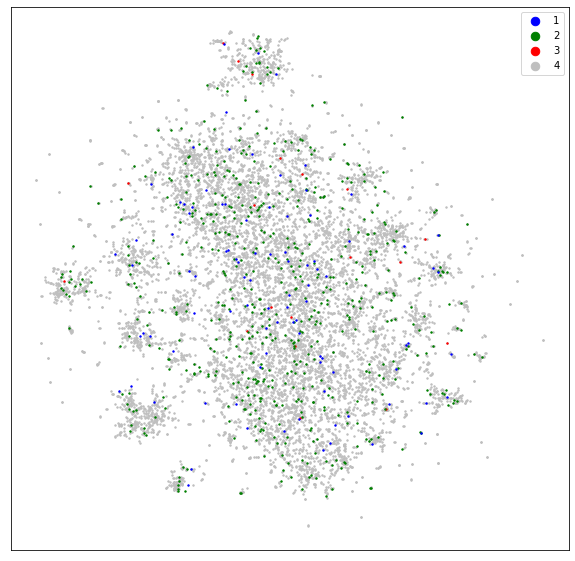

In [ ]:
# TODO: Visualize the coordinates
%matplotlib inline

#vapp.visualization(Y=label['label'],figure_size=10, scale=2)

fig = plt.figure()
coordinates = vapp.solver.coordinates
Y = np.asarray(label['label'])
classes = sorted(np.unique(Y))
mean = np.mean(coordinates, axis=0)
std = np.std(coordinates, axis=0)
inside = np.abs(coordinates - mean) < vapp.OUTLIER_THRESHOLD * std
indexes, = np.where(np.all(inside, axis=1))
coordinates = coordinates[indexes]
Y = Y[indexes]
classes = sorted(np.unique(Y))
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
c = ['blue','green','red','0.75']
for cls in classes:
  indexes, = np.where(Y == cls)
  ax.scatter(*coordinates[indexes].T, s=2, c=c[cls-1], zorder=-cls)
ax.set_xticks([])
ax.set_yticks([])
ax.legend(classes, markerscale=6, loc="upper right")          
plt.show()

Use the node classification labels to pick two classes of nodes. Color these nodes in the plot.

**Hint**: For those belonging to both classes, you can randomly assign it to one class, or use a third color to denote them.

Are the node embeddings learned from BlogCatalog good? Why or why not?

**Answer:** The visualisation builds a KNNGraph to represent the similarities between vectors. Since we cannot clearly see the distinction between the different labels and they are not grouped together, the node embeddings do not appear to be very good. The embeddings learned from BlogCatalog show little to no clustering of the data and the majority of the points appear in the centre of the mapping and tells us very little about the quality of the embedding. 

## 2. Graph Convolutional Networks (50 points)

For this part, we are going to implement the GCN model for node classification, where the Cora dataset is used for testing the model. 

The Cora dataset is avaible [here](https://drive.google.com/open?id=1wVguWcuHEfga09XgLPvC_PkRXTGEEInW). You could find several files there. Among those files, net.txt provides the edges between different nodes, and the three columns correspond to source nodes, target nodes and edge weights respectively. For feature.txt, it gives the features of nodes. For label.txt, it provides the node labels. train.txt, valid.txt, test.txt provide the training nodes, validation nodes and test nodes respectively.

The goal is to train a model on the training nodes, and further apply the model for classifying test nodes. In this process, you may use the validation nodes for hyper-parameter tuning and early stopping.

### 1) Implement the GCN model

In the first step, please implement a GCN model in the following code block.

In [ ]:
# We first download the repo to get access to data and some utility code (This is specifically for colab.)
!rm -rf pygcn/
!git clone https://github.com/tkipf/pygcn/

Cloning into 'pygcn'...
remote: Enumerating objects: 78, done.
remote: Total 78 (delta 0), reused 0 (delta 0), pack-reused 78
Unpacking objects: 100% (78/78), done.


In [ ]:
import os
ROOT_DIR='pygcn/'
DATA_DIR=os.path.join(ROOT_DIR, 'data/cora/') # this is where most of the data lives

In [ ]:
# utils
# credit: https://github.com/tkipf/pygcn

import numpy as np
import scipy.sparse as sp
import torch

def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot

def load_data(path=DATA_DIR, dataset="cora"):
    """Load citation network dataset (cora only for now)"""
    print('Loading {} dataset...'.format(dataset))

    idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset),
                                        dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    labels = encode_onehot(idx_features_labels[:, -1])

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset),
                                    dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    features = normalize(features)
    adj = normalize(adj + sp.eye(adj.shape[0]))

    idx_train = range(140)
    idx_val = range(140, 640)
    idx_test = range(1708, 2708)

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    return adj, features, labels, idx_train, idx_val, idx_test

def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

## Prepare the Data

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim

# Training settings
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Load data
adj, features, labels, idx_train, idx_val, idx_test = load_data()

if torch.cuda.is_available():
  features = features.cuda()
  adj = adj.cuda()
  labels = labels.cuda()
  idx_train = idx_train.cuda()
  idx_val = idx_val.cuda()
  idx_test = idx_test.cuda()

Loading cora dataset...


## Build the Model

In [ ]:
# TODO: Implement GCN here
import math
import torch
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module


class GraphConvolution(Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, nlayers):
        super(GCN, self).__init__()

        self.nlayers = nlayers
        self.gc = GraphConvolution(nfeat, nclass)
        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gcx = GraphConvolution(nhid, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
        self.dropout = dropout

    def forward(self, x, adj):
      if self.nlayers == 1:
        x = F.relu(self.gc(x,adj))
      else:
        x = F.relu(self.gc1(x, adj))
        for i in range((self.nlayers-2)):
          x = F.relu(self.gcx(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
      return F.log_softmax(x, dim=1)

## Train the Model

In [ ]:
import time

def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

# Train a model
def train(model, idx, optimizer, criterion):
  epoch_loss, epoch_acc = 0,0
  model.train()
  optimizer.zero_grad()
  predictions = model(features, adj)
  loss = criterion(predictions[idx], labels[idx])
  acc = accuracy(predictions[idx], labels[idx])
  loss.backward()
  optimizer.step()
  epoch_loss += loss.item()
  epoch_acc += acc.item()
  return epoch_loss, epoch_acc 

# Evaluate a model
def evaluate(model, idx, criterion):
  epoch_loss, epoch_acc = 0,0
  model.eval()
  predictions = model(features, adj)
  loss = criterion(predictions[idx], labels[idx])
  acc = accuracy(predictions[idx], labels[idx])
  epoch_loss += loss.item()
  epoch_acc += acc.item()
  return epoch_loss, epoch_acc 

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
# Parameters
N_EPOCHS = 200
n_epochs_stop = 10
n_layers = [1,2,3,4,5,6,7,8,9,10]
h_dims = [4,8,16,32,64,128]

criterion = F.nll_loss
results = []

for i in n_layers:
  print('\nTrain for: a number of layers of {0}'.format(i))

  # Model and optimizer
  model = GCN(nfeat=features.shape[1],
          nhid=16,
          nclass=labels.max().item() + 1,
          dropout=0.5,
          nlayers=i)
  optimizer = optim.Adam(model.parameters(),
                      lr=0.01, 
                      weight_decay=5e-4)
  
  if torch.cuda.is_available():
    model.cuda()
  
  best_valid_acc, best_model = 0.0, 0
  
  # Training
  for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss, train_acc = train(model, idx_train, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, idx_val, criterion)

    end_time = time.time()    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_acc > best_valid_acc:
      best_valid_acc = valid_acc
      best_model = model
      save = 'Best Model: Epoch {0} | Train Loss: {1} | Train Acc: {2}, Val. Loss: {3} | Val. Acc: {4}'.format(epoch, train_loss, train_acc, valid_loss, best_valid_acc)
    
    #print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    #print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    #print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
  print("Optimization Finished!")
  print(save)
  test_loss, test_acc = evaluate(best_model, idx_test, criterion)
  print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}')
  results.append(test_acc)
print(results)


Train for: a number of layers of 1
Optimization Finished!
Best Model: Epoch 191 | Train Loss: 1.6591506004333496 | Train Acc: 0.5571428571428572, Val. Loss: 1.808594822883606 | Val. Acc: 0.372
Test Loss: 1.832 | Test Acc: 0.32

Train for: a number of layers of 2
Optimization Finished!
Best Model: Epoch 111 | Train Loss: 0.6561869382858276 | Train Acc: 0.8857142857142857, Val. Loss: 0.8851757645606995 | Val. Acc: 0.81
Test Loss: 0.869 | Test Acc: 0.74

Train for: a number of layers of 3
Optimization Finished!
Best Model: Epoch 119 | Train Loss: 0.2689119279384613 | Train Acc: 0.95, Val. Loss: 0.5959522128105164 | Val. Acc: 0.8180000000000001
Test Loss: 0.986 | Test Acc: 0.68

Train for: a number of layers of 4
Optimization Finished!
Best Model: Epoch 199 | Train Loss: 0.31534990668296814 | Train Acc: 0.8928571428571428, Val. Loss: 1.219320297241211 | Val. Acc: 0.736
Test Loss: 2.076 | Test Acc: 0.61

Train for: a number of layers of 5
Optimization Finished!
Best Model: Epoch 122 | Trai

### 2) Performance w.r.t. the number of layers

Most GNN models only use a few layers for information propagation. Otherwise, they may suffer from the over-smoothing problem. To look into that, please fill in the following table to show the performance of your GNN model with respect to the number of propagation layers.

|               | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10|
|---------------|---|---|---|---|---|---|---|---|---|---|
| Test Accuracy | 0.3892  | 0.7906 | 0.6683  | 0.6823  | 0.48742  | 0.4386  | 0.2911   | 0.2911  | 0.2911   | 0.2911  |



Given the above result, please write down your observation and the potential reason based on your understanding.

**Observations:** The test accuracy drops as the number of layers increases. The test accuracy is best with two layers.

**Reasons:** The reason for this is that as the depth of the GCN increases (i.e. the number of layers) the model may suffer from the over-smoothing problem. Over-smoothing hinders training because it isolates output representations from the input features with increasing layers. Stacking more layers also leads to the vanishing gradient problem, eventually leading to features converging to the same value.

### 3) Performance w.r.t. the hidden dimension

Another important hyperparameter for graph neural networks is the dimension of hidden layers. In this part, you need to try different dimensions for the hidden layers, and further fill in the table below.

|               | 4 | 8 | 16| 32| 64|128|
|---------------|---|---|---|---|---|---|
| Test Accuracy | 0.735 | 0.787  | 0.837 | 0.832 | 0.828  | 0.825  |



Given the above result, please write down your observation and the potential reason based on your understanding.

**Observations:** The test accuracy rises with the size of the dimension of hidden layers, peaks, and then slowly begins to drop.

**Reasons:** The potential reason for this is that as the capacity increases, the model starts over-fitting to the training data and generalizes poorly to the testing data. In the case of 128 layers, the corresponding training accuracy was of 99.29%, which is a clear indicator of over-fitting (see the corresponding training example at the end of the Notebook).



---



## Hidden Layer Dimension of 128 Training Example

In [ ]:
model = GCN(nfeat=features.shape[1],
            nhid=128,
            nclass=labels.max().item() + 1,
            dropout=0.5,
            nlayers=2)
optimizer = optim.Adam(model.parameters(),
                       lr=0.01, 
                       weight_decay=5e-4)

criterion = F.nll_loss

if torch.cuda.is_available():
    model.cuda()
    features = features.cuda()
    adj = adj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()
    
N_EPOCHS = 200

best_valid_acc = 0.0

for epoch in range(N_EPOCHS):
  start_time = time.time()

  train_loss, train_acc = train(model, idx_train, optimizer, criterion)
  valid_loss, valid_acc = evaluate(model, idx_val, criterion)

  end_time = time.time()    
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  if valid_acc > best_valid_acc:
    best_valid_acc = valid_acc
  
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

print("Optimization Finished!")
test_loss, test_acc = evaluate(model, idx_test, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}')

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 2.060 | Train Acc: 8.57%
	 Val. Loss: 1.968 |  Val. Acc: 18.67%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 1.965 | Train Acc: 18.57%
	 Val. Loss: 1.907 |  Val. Acc: 14.00%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 1.894 | Train Acc: 20.71%
	 Val. Loss: 1.856 |  Val. Acc: 43.67%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 1.843 | Train Acc: 39.29%
	 Val. Loss: 1.810 |  Val. Acc: 37.67%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 1.790 | Train Acc: 39.29%
	 Val. Loss: 1.766 |  Val. Acc: 36.33%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 1.731 | Train Acc: 40.00%
	 Val. Loss: 1.725 |  Val. Acc: 37.33%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 1.678 | Train Acc: 42.14%
	 Val. Loss: 1.689 |  Val. Acc: 40.33%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 1.623 | Train Acc: 45.71%
	 Val. Loss: 1.656 |  Val. Acc: 41.00%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 1.595 | Train Acc: 43.57%
	 Val. Loss: 1.628 |  Val. Acc: 41.00%
Epoch: 10 | Epoch Time: 0m 0s

## Hyperparameter Search

In [ ]:
N_EPOCHS = 400
n_epochs_stop = 100
learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5] 
dropout_rates = [0.25, 0.5, 0.75]

criterion = F.nll_loss
best_overall_valid_acc, save = 0.0, 0

for d in dropout_rates:
  for l in learning_rates:
    print('\nTrain for: learning rate {0}, droupout rate {1}'.format(l, d))
    model = GCN(nfeat=features.shape[1],
            nhid=16,
            nclass=labels.max().item() + 1,
            dropout=d,
            nlayers=2)
    optimizer = optim.Adam(model.parameters(),
                       lr=l, 
                       weight_decay=5e-4)
    
    if torch.cuda.is_available():
      model.cuda()
    
    best_valid_acc = 0.0
    for epoch in range(N_EPOCHS):
      start_time = time.time()

      train_loss, train_acc = train(model, idx_train, optimizer, criterion)
      valid_loss, valid_acc = evaluate(model, idx_val, criterion)

      end_time = time.time()    
      epoch_mins, epoch_secs = epoch_time(start_time, end_time)

      if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        epochs_no_improve = 0
        if valid_acc > best_overall_valid_acc:
          best_overall_valid_acc = valid_acc
          save = '\nBest model: learning rate {0}, droupout rate {1}'.format(l, d)
      else:
        epochs_no_improve += 1
        # Check early stopping condition
        if epochs_no_improve == n_epochs_stop:
          print('Early stopping!')
          epochs_no_improve=0
          break
      
      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

print("Optimization Finished!")
print(save)
print(best_overall_valid_acc)
test_loss, test_acc = evaluate(model, idx_test, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}')


Streaming output truncated to the last 5000 lines.
	Train Loss: 0.333 | Train Acc: 97.14%
	 Val. Loss: 0.648 |  Val. Acc: 80.60%
Epoch: 272 | Epoch Time: 0m 0s
	Train Loss: 0.281 | Train Acc: 97.86%
	 Val. Loss: 0.649 |  Val. Acc: 81.00%
Epoch: 273 | Epoch Time: 0m 0s
	Train Loss: 0.289 | Train Acc: 98.57%
	 Val. Loss: 0.648 |  Val. Acc: 80.80%
Epoch: 274 | Epoch Time: 0m 0s
	Train Loss: 0.326 | Train Acc: 98.57%
	 Val. Loss: 0.647 |  Val. Acc: 80.60%
Epoch: 275 | Epoch Time: 0m 0s
	Train Loss: 0.304 | Train Acc: 97.86%
	 Val. Loss: 0.646 |  Val. Acc: 80.80%
Epoch: 276 | Epoch Time: 0m 0s
	Train Loss: 0.310 | Train Acc: 97.14%
	 Val. Loss: 0.646 |  Val. Acc: 80.60%
Epoch: 277 | Epoch Time: 0m 0s
	Train Loss: 0.308 | Train Acc: 97.86%
	 Val. Loss: 0.646 |  Val. Acc: 81.20%
Epoch: 278 | Epoch Time: 0m 0s
	Train Loss: 0.304 | Train Acc: 93.57%
	 Val. Loss: 0.646 |  Val. Acc: 80.60%
Epoch: 279 | Epoch Time: 0m 0s
	Train Loss: 0.280 | Train Acc: 96.43%
	 Val. Loss: 0.647 |  Val. Acc: 80.00%